In [0]:
#@title License
# Copyright 2019 BDL Benchmarks Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or  implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================

# Bayesian Deep Learning Benchmarks

**Bayesian Deep Learning Benchmarks** (BDL Benchmarks or `bdlb` for short), is an open-source framework that aims to bridge the gap between the design of deep probabilistic machine learning models and their application to real-world problems, hosted on [GitHub](https://github.com/OATML/bdl-benchmarks).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/OATML/bdl-benchmarks/blob/alpha/notebooks/diabetic_retinopathy_diagnosis.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/OATML/bdl-benchmarks/blob/alpha/notebooks/diabetic_retinopathy_diagnosis.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [2]:
#@title Dependencies & Prerequisites
!pip3 install --quiet --upgrade git+https://github.com/OATML/bdl-benchmarks.git

     |████████████████████████████████| 348.9MB 108kB/s 
     |████████████████████████████████| 1.1MB 47.0MB/s 
     |████████████████████████████████| 686kB 43.3MB/s 
     |████████████████████████████████| 3.1MB 54.4MB/s 
     |████████████████████████████████| 501kB 51.5MB/s 


In [3]:
#@title Imports

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import functools

import numpy as np
import scipy.stats
import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers
import matplotlib.pyplot as plt

if tf.test.gpu_device_name() != "/device:GPU:0":
  raise OSError("GPU device not found")
else:
  print("SUCCESS: Found GPU: {}".format(tf.test.gpu_device_name()))

import bdlb
from bdlb.core.plotting import leaderboard
from bdlb.core.constants import DIABETIC_RETINOPATHY_DIAGNOSIS_URL_MEDIUM
from bdlb.core.constants import LEADERBOARD_DIR_URL

SUCCESS: Found GPU: /device:GPU:0


## [Diabetic Retinopathy Diagnosis Benchmark](https://github.com/OATML/bdl-benchmarks/tree/alpha/baselines/diabetic_retinopathy_diagnosis)

The benchmark that we use in this example is built on the [Kaggle Diabetic Retinopathy (DR) Detection Challenge data](https://www.kaggle.com/c/diabetic-retinopathy-detection/overview).
It consists of 35,126 training images and 53,576 test images. We hold-out 20% of the training data as a validation set.
Each image is graded by a specialist on the following scale: 0 -- No DR, 1 -- Mild DR, 2 -- Moderate DR, 3 -- Severe DR and 4 -- Proliferative DR.
We recast the 5-class classification task as binary classification which is easily applicable to any BDL classification algorithm by asking the user to classify whether each image has sight-threatening DR, which is defined as Moderate DR or greater (classes 2-4) following [_Leibig et al._](https://www.nature.com/articles/s41598-017-17876-z.pdf).
The data are unbalanced, with  only 19.6% of the training set and 19.2% of the test set having a positive label.

In [4]:
#@title Fetch Data (in TFRecords) & Leaderboard

!pip3 install --quiet --upgrade gdown
!gdown $DIABETIC_RETINOPATHY_DIAGNOSIS_URL_MEDIUM
!mkdir -p data/diabetic_retinopathy_diagnosis
!unzip -qq medium.zip
!mv medium data/diabetic_retinopathy_diagnosis
!rm -rf medium.zip

!gdown $LEADERBOARD_DIR_URL
!unzip -qq leaderboard.zip
!rm -rf leaderboard.zip

Downloading...
From: https://drive.google.com/uc?id=1WAvS-pQsVLxUJiClmKLnVNQkoKmRt2I_
To: /content/medium.zip
687MB [00:05, 121MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LQeAfqMQa4lot09qAuzWa3t6attmCeG-
To: /content/leaderboard.zip
100% 4.64k/4.64k [00:00<00:00, 6.73MB/s]


In [0]:
#@title Hyperparameters { display-mode: "form" }
BATCH_SIZE = 16 #@param {type:"integer"}
NUM_EPOCHS = 10 #@param {type:"slider", min:1, max:100, step:1}
DROPOUT_RATE = 0.1 #@param {type:"slider", min:0, max:1.0, step:0.05}
NUM_MCDROPOUT_SAMPLES = 10 #@param {type:"integer"}

LEVEL = "medium" #@param ["medium"]

input_shape = {"medium": (256, 256, 3),
               "realworld": (512, 512, 3)}[LEVEL]
learning_rate = 1e-3
l2_reg = 5e-5

In [0]:
#@title Helper Functions

def visualize_tfdataset(tfdataset, num_samples):
  """Visualizes `num_samples` from the `tfdataset`."""
  
  def to01(image):
    """Normalizes image to float [0, 1]."""
    min_ = np.min(image)
    max_ = np.max(image)
    return (image - min_) / (max_ - min_)
  
  for X, y in tfdataset.take(1):
    images = X.numpy()
    labels = y.numpy()
    B, _, _, _ = images.shape
    num_samples = min(num_samples, B)
    fig, axes = plt.subplots(figsize=(2.0*num_samples, 2.0), ncols=num_samples)
    for i in range(num_samples):
      ax = axes[i]
      ax.imshow(to01(images[i]))
      ax.axis("off")
      ax.set(title="healthy" if labels[i] == 0 else "diseased")
    fig.show()

### Benchmark API

The benchmarks can be easily loaded using `bdlb.load(benchmark, level, data_dir, batch_size)`.
All the data management (i.e. download, prepare, preprocess, load, batch and prefetch) is abstracted away from the user and is **compatible with any deep learning framework**!

In [0]:
dtask = bdlb.load(
    benchmark="diabetic_retinopathy_diagnosis",
    level=LEVEL,
    batch_size=BATCH_SIZE,
    data_dir="data",
    download_and_prepare=False,
)
ds_train, ds_validation, ds_test = dtask.datasets

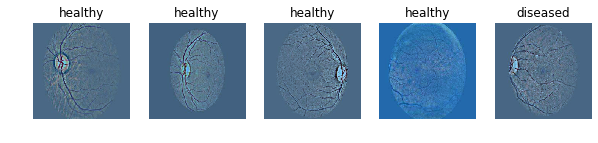

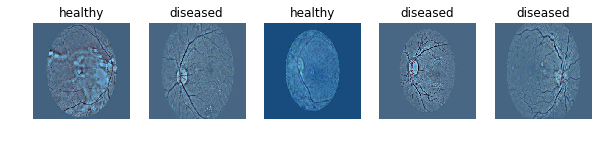

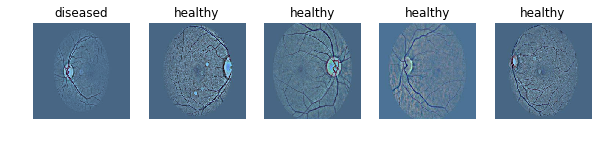

In [9]:
#@title Visualize Data
visualize_tfdataset(ds_train, num_samples=5)
visualize_tfdataset(ds_validation, num_samples=5)
visualize_tfdataset(ds_test, num_samples=5)

### Model Definition

Implementations of tuned [baselines](https://github.com/OATML/bdl-benchmarks/tree/alpha/baselines/diabetic_retinopathy_diagnosis) are provided for each benchmark, as well as their [leaderboards](https://github.com/OATML/bdl-benchmarks/tree/alpha/leaderboard/diabetic_retinopathy_diagnosis).

For this colab, we implement a naive 1-hidden layer feedforward neural network in [`TensorFlow 2.0`](https://www.tensorflow.org/beta/) to illustrate the workflow, using Monte Carlo Dropout for estimating the predictive entropy.

In [10]:
classifier = tfk.Sequential([
    tfkl.InputLayer(input_shape),
    tfkl.Flatten(),
    tfkl.Dense(units=32, kernel_regularizer=tfk.regularizers.l2(l2_reg)),
    tfkl.Activation("relu"),
    tfkl.Dropout(DROPOUT_RATE),
    tfkl.Dense(units=1, kernel_regularizer=tfk.regularizers.l2(l2_reg)),
    tfkl.Activation("sigmoid"),
])
classifier.compile(loss=dtask.loss(),
                   optimizer=tfk.optimizers.Adam(learning_rate),
                   metrics=dtask.metrics())
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 196608)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                6291488   
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 6,291,521
Trainable params: 6,291,521
Non-trainable params: 0
______________________________________________

In [11]:
#@title Train Model
history = classifier.fit(
    ds_train,
    epochs=NUM_EPOCHS,
    steps_per_epoch=5,
    validation_data=ds_validation,
    validation_steps=5,
    class_weight=dtask.class_weight(),
)

Epoch 1/10


W0615 11:42:28.904791 140461055330176 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


5/5 [==============================] - 5s 905ms/step - loss: 3.4083 - binary_accuracy: 0.7375 - auc: 0.4646 - val_loss: 2.1255 - val_binary_accuracy: 0.8625 - val_auc: 0.5000
Epoch 2/10
5/5 [==============================] - 1s 232ms/step - loss: 2.7045 - binary_accuracy: 0.8250 - auc: 0.5000 - val_loss: 2.1268 - val_binary_accuracy: 0.8625 - val_auc: 0.5000
Epoch 3/10
5/5 [==============================] - 1s 240ms/step - loss: 3.4769 - binary_accuracy: 0.7750 - auc: 0.5000 - val_loss: 2.3206 - val_binary_accuracy: 0.8500 - val_auc: 0.5000
Epoch 4/10
5/5 [==============================] - 1s 236ms/step - loss: 3.2850 - binary_accuracy: 0.7875 - auc: 0.5000 - val_loss: 1.9357 - val_binary_accuracy: 0.8750 - val_auc: 0.5000
Epoch 5/10
5/5 [==============================] - 1s 223ms/step - loss: 2.7072 - binary_accuracy: 0.8250 - auc: 0.5000 - val_loss: 2.1291 - val_binary_accuracy: 0.8625 - val_auc: 0.5000
Epoch 6/10
5/5 [==============================] - 1s 224ms/step - loss: 2.9005 - 

In [0]:
def predict(x):
  """Monte Carlo dropout uncertainty estimator.
  
  Args:
    x: `numpy.ndarray`, datapoints from input space,
      with shape [B, H, W, 3], where B the batch size and
      H, W the input images height and width accordingly.

  Returns:
    mean: `numpy.ndarray`, predictive mean, with shape [B].
    uncertainty: `numpy.ndarray`, ncertainty in prediction,
      with shape [B].
  """
  # Get shapes of data
  B, _, _, _ = x.shape

  # Monte Carlo samples from different dropout mask at test time
  mc_samples = np.asarray(
      [classifier(x, training=True)
       for _ in range(NUM_MCDROPOUT_SAMPLES)]).reshape(-1, B)

  # Bernoulli output distribution
  dist = scipy.stats.bernoulli(mc_samples.mean(axis=0))

  # Predictive mean calculation
  mean = dist.mean()

  # Use predictive entropy for uncertainty
  uncertainty = dist.entropy()
  
  return mean, uncertainty

### Evaluate Model

Machine learning researchers often evaluate their predictions directly on the whole test set.
But, in fact, in real-world settings we have additional choices available, like asking for more information when we are uncertain.
Because of the importance of accurate diagnosis, it would be unreasonable _not_ to ask for further scans of the most ambiguous cases.
Moreover, in this dataset, many images feature camera artefacts that distort results.
In these cases, it is critically important that a model is able to tell when the information provided to it is not sufficiently reliable to classify the patient.
Just like real medical professionals, any diagnostic algorithm should be able to flag cases that require more investigation by medical experts.

<p align="center">
<img src="http://www.cs.ox.ac.uk/people/angelos.filos/assets/bdl-benchmarks/diagnosis.png" >
</p>

This task is illustrated in the figure above, where a threshold, τ, is used to flag cases as certain and uncertain, with uncertain cases referred to an expert. Alternatively, the uncertainty estimates could be used to come up with a priority list, which could be matched to the available resources of a hospital, rather than waste diagnostic resources on patients for whom the diagnosis is clear cut.

In order to simulate this process of referring the uncertain cases to experts and relying on the model's predictions for cases it is certain of, we assess the techniques by their diagnostic accuracy and area under receiver-operating-characteristic (ROC) curve, as a function of the
referral rate. We expect the models with well-calibrated uncertainty to refer their least confident predictions to experts,
improving their performance as the number of referrals increases.

The accuracy of the binary classifier is defined as the ratio of correctly classified data-points over the size of the population.
The receiver-operating-characteristic (ROC) curve illustrates
the diagnostic ability of a binary classifier system as its discrimination threshold is varied.
It is created by plotting the true positive rate (a.k.a. sensitivity) against the false positive rate (a.k.a. 1 - sensitivity).
The quality of such a ROC curve can be summarized by its area under the curve (AUC), which varies between 0.5 (chance level) and 1.0 (best possible value).

10it [00:02,  5.11it/s]


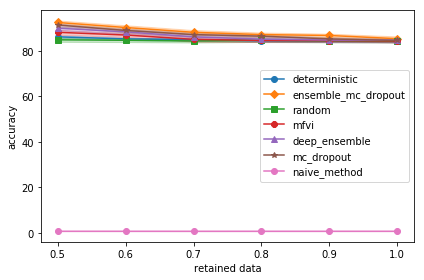

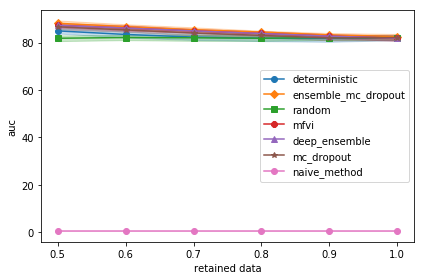

In [13]:
results = dtask.evaluate(predict,
                         dataset=ds_test.take(10),
                         name="naive_method")
leaderboard("diabetic_retinopathy_diagnosis",
            results,
            leaderboard_dir="leaderboard")

| Method              | AUC<br>(50% data retained)  | Accuracy<br>(50% data retained) | AUC<br>(100% data retained) | Accuracy<br>(100% data retained) |
| ------------------- | :-------------------------: | :-----------------------------: | :-------------------------: | :-------------------------------: |
| Ensemble MC Dropout | 88.1 ± 1.2                  | 92.4 ± 0.9                      | 82.5 ± 1.1                  | 85.3 ± 1.0                        |
| MC Dropout          | 87.8 ± 1.1                  | 91.3 ± 0.7                      | 82.1 ± 0.9                  | 84.5 ± 0.9                        |
| Deep Ensembles      | 87.2 ± 0.9                  | 89.9 ± 0.9                      | 81.8 ± 1.1                  | 84.6 ± 0.7                        |
| Mean-field VI       | 86.6 ± 1.1                  | 88.1 ± 1.1                      | 82.1 ± 1.2                  | 84.3 ± 0.7                        |
| Deterministic       | 84.9 ± 1.1                  | 86.1 ± 0.6                      | 82.0 ± 1.0                  | 84.2 ± 0.6                        |
| Random              | 81.8 ± 1.2                  | 84.8 ± 0.9                      | 82.0 ± 0.9                  | 84.2 ± 0.5                        |